In [1]:
import zeus21
from matplotlib import pyplot as plt
import numpy as np
from zeus21 import LIM
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d

import scipy.fftpack as fft
from scipy import ndimage

import functools

#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
plt.rcParams['lines.linewidth'] = 2
colors = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

In [2]:
# define all the input params
CosmoParams_input = zeus21.Cosmo_Parameters_Input()
CosmoParams_use,ClassyCosmo_use, CorrFclass_use ,HMFintclass_use =  zeus21.cosmo_wrapper(CosmoParams_input)
AstroParams_use = zeus21.Astro_Parameters(CosmoParams_use,STOCHASTICITY = False,)

ZMIN = 10.0 #down to which z we compute the evolution
CoeffStructure_21_use = zeus21.get_T21_coefficients(CosmoParams_use, ClassyCosmo_use, AstroParams_use, HMFintclass_use, zmin=ZMIN)

CoeffStructure_use = zeus21.get_T21_coefficients(CosmoParams_use, ClassyCosmo_use, AstroParams_use, HMFintclass_use, zmin=ZMIN)
RSDMODE = 0 #which RSD mode you want, 0 is no RSDs (real space), 1 is spherical (as simulations usually take), 2 is mu~1 (outside the wedge, most relevant for observations)
PS21_use = zeus21.Power_Spectra(CosmoParams_use, AstroParams_use, ClassyCosmo_use, CorrFclass_use, CoeffStructure_use, RSD_MODE = RSDMODE)

Lbox = 50
Nbox = 50 

In [3]:
LineParams_input_use = zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 2,  
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4-0.07*10,
                 CII_alpha_SFR_z = 0.,
                 CII_beta_SFR_0 = 7.1-0.07*10,
                 CII_beta_SFR_z = 0.,
                 CII_sigma_LSFR = 0.)

LineParams_use = zeus21.Line_Parameters(LineParams_input_use) 

In [4]:
def get_deltaR_sigmaR(CoeffStructure_21,CosmoParams,HMFintclass,Nsigmad = 1.0,Nds = 2 ):

    # define \delta_R
    deltatab_norm = np.linspace(-Nsigmad,Nsigmad,Nds)

    # this is just for dimensions
    zArray, rArray, mArray, deltaNormArray = np.meshgrid(CoeffStructure_21.zintegral, CoeffStructure_21.Rtabsmoo, HMFintclass.Mhtab, deltatab_norm, indexing = 'ij', sparse = True)
    # rArray is between 0.5 to 2000 Mpc, for integration 
    rGreaterArray = np.zeros_like(zArray) + rArray
    rGreaterArray[CosmoParams.chiofzint(zArray) + rArray >= CosmoParams.chiofzint(50)] = np.nan

    zGreaterArray = CosmoParams.zfofRint(CosmoParams.chiofzint(zArray) + rGreaterArray)

    # variance smoothed over R > Rh
    sigmaR = np.zeros((len(CoeffStructure_21.zintegral), len(CoeffStructure_21.Rtabsmoo), 1, 1))
    whereNotNans = np.invert(np.isnan(rGreaterArray))
    sigmaR[whereNotNans] = HMFintclass.sigmaRintlog((np.log(rGreaterArray)[whereNotNans], zGreaterArray[whereNotNans]))

    # tilde delta 
    deltaArray = deltaNormArray * sigmaR

    return deltaArray, sigmaR, deltatab_norm, rArray

In [5]:
#def SFRD_from_deltaR(CoeffStructure_21,CosmoParams,HMFintclass,AstroParams,Nsigmad = 1.0,Nds = 2):
def SFRD_from_deltaR(CoeffStructure_21):

    # # tilde delta 
    # deltaArray, sigmaR, deltatab_norm, _ = get_deltaR_sigmaR(CoeffStructure_21,CosmoParams,HMFintclass,Nsigmad,Nds)

    # # this is just for dimensions
    # zArray, rArray, mArray, _ = np.meshgrid(CoeffStructure_21.zintegral, CoeffStructure_21.Rtabsmoo, HMFintclass.Mhtab, deltatab_norm, indexing = 'ij', sparse = True)
    # # rArray is between 0.5 to 2000 Mpc, for integration 
    # rGreaterArray = np.zeros_like(zArray) + rArray
    # rGreaterArray[CosmoParams.chiofzint(zArray) + rArray >= CosmoParams.chiofzint(50)] = np.nan
    # zGreaterArray = CosmoParams.zfofRint(CosmoParams.chiofzint(zArray) + rGreaterArray)

    # # variance smoothed over Rh = R(M_h) with Mh between 1e5 and 1e14 
    # sigmaM = np.zeros((len(CoeffStructure_21.zintegral), len(CoeffStructure_21.Rtabsmoo), len(HMFintclass.Mhtab), 1)) ###HAC: Is this necessary?
    # sigmaM = HMFintclass.sigmaintlog((np.log(mArray), zGreaterArray))

    # modSigmaSq = sigmaM**2 - sigmaR**2
    # indexTooBig = (modSigmaSq <= 0.0)
    # modSigmaSq[indexTooBig] = np.inf #if sigmaR > sigmaM the halo does not fit in the radius R. Cut the sum
    # modSigma = np.sqrt(modSigmaSq)

    # nu0 = CosmoParams.delta_crit_ST / sigmaM
    # nu0[indexTooBig] = 1.0
    # modd = CosmoParams.delta_crit_ST - deltaArray
    # nu = modd / modSigma
    # C_arb = 1.6
    # EPS_HMF_corr = C_arb * (nu/nu0) * (sigmaM/modSigma)**2.0 * np.exp(-CosmoParams.a_corr_EPS * (nu**2-nu0**2)/2.0 ) * (1.0 + deltaArray)
    # integrand_II = EPS_HMF_corr * zeus21.sfrd.SFRD_II_integrand(AstroParams, CosmoParams, HMFintclass, mArray, zGreaterArray, zGreaterArray)

    # # integrand of the SFRD
    # integrand_II = EPS_HMF_corr * zeus21.sfrd.SFRD_II_integrand(AstroParams, CosmoParams, HMFintclass, mArray, zGreaterArray, zGreaterArray)
        
    # SFRD_II_dR = np.trapezoid(integrand_II, HMFintclass.logtabMh, axis = 2) 

    SFRD_II_dR = CoeffStructure_21.SFRD_II_dR

    return SFRD_II_dR

In [6]:
def SFRD_approx(deltaArray, sigmaR, CoeffStructure_21):

    use_gamma = CoeffStructure_21.gamma_II_index2D 
    tilde_deltaArray = deltaArray - (use_gamma * sigmaR**2/2.)[:,:,np.newaxis] 
    SFRD_deltaR =  np.exp(use_gamma[:,:,np.newaxis] * tilde_deltaArray)

    return SFRD_deltaR

In [7]:
def SFRD_box(Lbox,Nbox,PS21,CoeffStructure21,CosmoParams,HMFintclass,AstroParams):
    
    Mapz12 = zeus21.CoevalMaps(CoeffStructure21, PS21, 12., KIND=1,Lbox=Lbox,Nbox=Nbox) #can set Lbox, Nbox, and seed

    delta_box = Mapz12.deltamap

    variance = np.var(delta_box)
    sigmaR = np.sqrt(variance)

    deltabox_flattened = (delta_box * sigmaR).flatten()

    zArray, mArray, deltaArray = np.meshgrid(CoeffStructure21.zintegral, HMFintclass.Mhtab, deltabox_flattened, indexing = 'ij', sparse = True)

    sigmaM = HMFintclass.sigmaintlog((np.log(mArray), zArray))

    modSigmaSq = sigmaM**2 - sigmaR**2
    indexTooBig = (modSigmaSq <= 0.0)
    modSigmaSq[indexTooBig] = np.inf #if sigmaR > sigmaM the halo does not fit in the radius R. Cut the sum
    modSigma = np.sqrt(modSigmaSq)

    nu0 = CosmoParams.delta_crit_ST / sigmaM
    nu0[indexTooBig] = 1.0
    modd = CosmoParams.delta_crit_ST - deltaArray
    nu = modd / modSigma

    EPS_HMF_corr = (nu/nu0) * (sigmaM/modSigma)**2.0 * np.exp(-CosmoParams.a_corr_EPS * (nu**2-nu0**2)/2.0 ) * (1.0 + deltaArray)

    HMF_curr = np.exp(HMFintclass.logHMFint((np.log(mArray), zArray)))
    SFRtab_currII = zeus21.sfrd.SFR_II(AstroParams, CosmoParams, HMFintclass, mArray, zArray, 0.)

    integrand = EPS_HMF_corr *  HMF_curr * SFRtab_currII * HMFintclass.Mhtab[np.newaxis,:,np.newaxis]

    SFRDbox_flattend = np.trapezoid(integrand, HMFintclass.logtabMh, axis = 1) 

    SFRD_box = SFRDbox_flattend.reshape(len(zArray),Nbox,Nbox,Nbox)
    delta_box_sigmaR = deltaArray.reshape(Nbox,Nbox,Nbox)

    return delta_box_sigmaR, SFRD_box

In [8]:
def line_box(Line_Params,PS21,CoeffStructure21,CosmoParams,HMFintclass,AstroParams):

    delta_box_sigmaR_vals, SFRD_box_vals = SFRD_box(Lbox,Nbox,PS21,CoeffStructure21,CosmoParams,HMFintclass,AstroParams)   

    alpha_SFR = (Line_Params.CII_alpha_SFR_0 + Line_Params.CII_alpha_SFR_z * CoeffStructure21.zintegral)[:,np.newaxis,np.newaxis,np.newaxis]

    beta_SFR = (Line_Params.CII_beta_SFR_0 + Line_Params.CII_beta_SFR_z * CoeffStructure21.zintegral)[:,np.newaxis,np.newaxis,np.newaxis]

    log10_L = alpha_SFR * np.log10(SFRD_box_vals) + beta_SFR     

    L_box = pow(10,log10_L)

    return L_box

In [9]:
def top_hat_filter(k, R):
    """Top-hat filter in k-space, avoiding division by zero."""
    kR = k * R
    W = np.zeros_like(k)
    mask = kR > 0
    W[mask] = 3 * (np.sin(kR[mask]) - kR[mask] * np.cos(kR[mask])) / (kR[mask]**3)
    W[~mask] = 1.0  # Ensure W(0) = 1
    
    return W

In [10]:
def smoothed_boxes(R,Lbox,Nbox,PS21,CoeffStructure21,CosmoParams,HMFintclass,AstroParams,Line_Params,smooth_type):

    density_vals, SFRD_box_vals = SFRD_box(Lbox,Nbox,PS21,CoeffStructure21,CosmoParams,HMFintclass,AstroParams)
    
    line_box_vals = line_box(Line_Params,PS21,CoeffStructure21,CosmoParams,HMFintclass,AstroParams)

    if 2*R < Lbox/Nbox:
        print('\n\nYou cannot smooth over R smaller than the cell size!!!\n\n')
        return density_vals,SFRD_box_vals,line_box_vals
    elif 2*R > Lbox:
        print('\n\nYou cannot smooth over R larger than the box size!!!\n\n')
        return density_vals,SFRD_box_vals,line_box_vals
 
    input_ = fft.fftn(density_vals)
    if smooth_type == 'gauss':
        result_fft = ndimage.fourier_gaussian(input_, sigma= R )
        density_smoothed_R = np.abs(np.fft.ifftn(result_fft)) * np.sign(density_vals)
    elif smooth_type == 'tophat':

        N = density_vals.shape[0]  # Assuming cubic box
        dx = len(density_vals) / N  # Grid spacing
        k_freq = 2 * np.pi * fft.fftfreq(N, d=dx)  # Correct k definition
        
        # Create a 3D grid of k values
        kx, ky, kz = np.meshgrid(k_freq, k_freq, k_freq, indexing="ij")
        k_mag = np.sqrt(kx**2 + ky**2 + kz**2)
        
        # Apply filter
        input_ *= top_hat_filter(k_mag, R)
        density_smoothed_R = fft.ifftn(input_).real

    SFRD_smoothed_R_z = []
    LIM_smoothed_R_z = []
    for zv in tqdm(range(len(SFRD_box_vals))):

        input_ = fft.fftn(SFRD_box_vals[zv])
        input_LIM = fft.fftn(line_box_vals[zv])
        if smooth_type == 'gauss':
            result_fft = ndimage.fourier_gaussian(input_, sigma= R / (2 * np.sqrt(2 * np.log(2))))
            SFRD_smoothed_R_z.append(np.abs(np.fft.ifftn(result_fft)))

            result_fft_LIM = ndimage.fourier_gaussian(input_LIM, sigma= R / (2 * np.sqrt(2 * np.log(2))))
            LIM_smoothed_R_z.append(np.abs(np.fft.ifftn(result_fft_LIM)))

        elif smooth_type == 'tophat':

            # Apply filter
            input_ *= top_hat_filter(k_mag, R)
            input_LIM *= top_hat_filter(k_mag, R)

            # Inverse Fourier transform
            SFRD_smoothed_R_z.append(fft.ifftn(input_).real)
            LIM_smoothed_R_z.append(fft.ifftn(input_LIM).real)


    return np.asarray(density_smoothed_R), np.asarray(SFRD_smoothed_R_z), np.asarray(LIM_smoothed_R_z)

In [11]:
# tilde delta 
zid = 0
z = round(CoeffStructure_21_use.zintegral[zid],0)
zid1 = 21
z1 = round(CoeffStructure_21_use.zintegral[zid1],0)
zid2 = 35
z2 = round(CoeffStructure_21_use.zintegral[zid2],0)

In [12]:
map_delta, map_SFRD_z = SFRD_box(Lbox,Nbox,PS21=PS21_use,CoeffStructure21=CoeffStructure_21_use,CosmoParams=CosmoParams_use,HMFintclass=HMFintclass_use,AstroParams=AstroParams_use)
map_SFRD_z = [np.log10(map_SFRD_z[zid]),np.log10(map_SFRD_z[zid1]),np.log10(map_SFRD_z[zid2])]

In [13]:
map_line_z = line_box(LineParams_use,PS21_use,CoeffStructure_21_use,CosmoParams_use,HMFintclass_use,AstroParams_use)

100%|██████████| 64/64 [00:01<00:00, 56.34it/s]


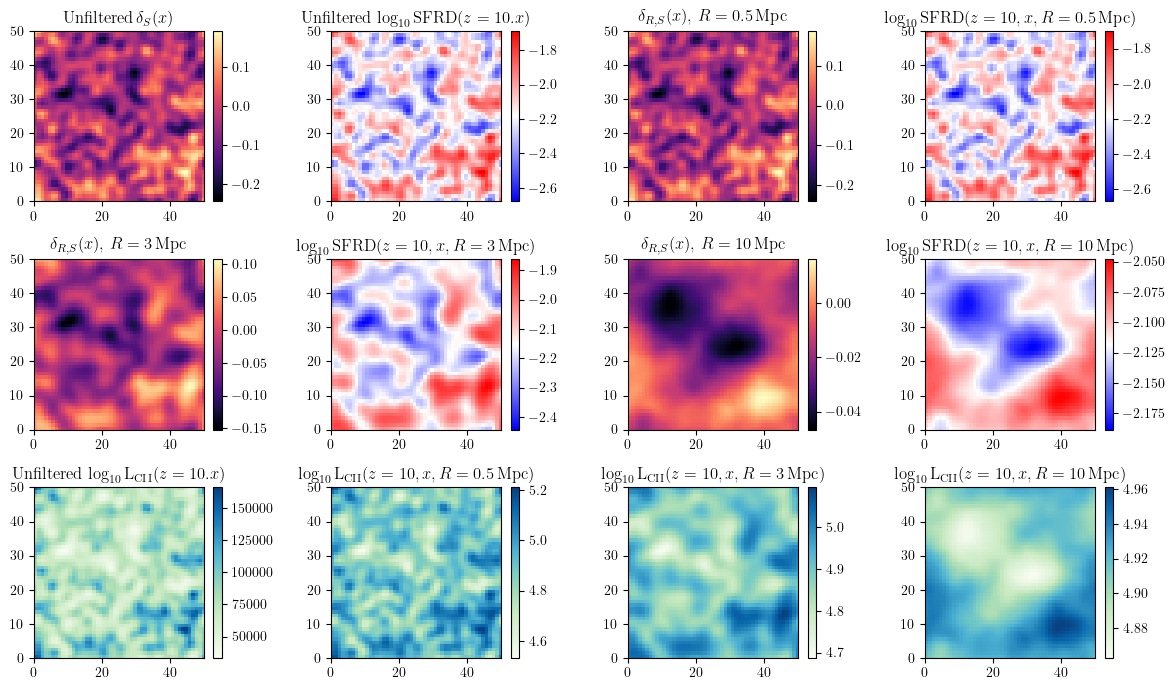

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12, 7))

_islice = 0

im = ax[0,0].imshow(map_delta[_islice],extent=(0,Lbox,0,Lbox),cmap='magma') 
cbar1 = fig.colorbar(im, ax=ax[0,0], fraction=0.046, pad=0.04)
ax[0,0].set_title(r'${\rm Unfiltered}\,\delta_S(x)$')

im = ax[0,1].imshow(map_SFRD_z[0][_islice],extent=(0,Lbox,0,Lbox),cmap='bwr',)
cbar1 = fig.colorbar(im, ax=ax[0,1], fraction=0.046, pad=0.04)
ax[0,1].set_title(r'${\rm Unfiltered}\,\log_{10}{\rm SFRD}(z=%g$'%z+r'$.{x})$')

im = ax[2,0].imshow(map_line_z[0][_islice],extent=(0,Lbox,0,Lbox),cmap='GnBu',)
cbar1 = fig.colorbar(im, ax=ax[2,0], fraction=0.046, pad=0.04)
ax[2,0].set_title(r'${\rm Unfiltered}\,\log_{10}{\rm L_{CII}}(z=%g$'%z+r'$.{x})$')


# im = ax[2].imshow(map_SFRD_z[1][_islice],extent=(0,Lbox,0,Lbox),cmap='bwr',)
# cbar1 = fig.colorbar(im, ax=ax[2], fraction=0.046, pad=0.04)
# ax[2].set_title(r'${\rm Unfiltered}\,\log_{10}{\rm SFRD}(z=%g$'%z1+r'$,{x})$')

# im = ax[3].imshow(map_SFRD_z[2][_islice],extent=(0,Lbox,0,Lbox),cmap='bwr',)
# cbar1 = fig.colorbar(im, ax=ax[3], fraction=0.046, pad=0.04)
# ax[3].set_title(r'${\rm Unfiltered}\,\log_{10}{\rm SFRD}(z=%g$'%z2+r'$,{x})$')

# plt.tight_layout()
# plt.savefig('./unfiltered_fields.png')

R_vals = [0.5,3,10]
axes = [[ax[0,2],ax[0,3]],[ax[1,0],ax[1,1]],[ax[1,2],ax[1,3]]]
axes_LIM = [ax[2,1],ax[2,2],ax[2,3]]
for r in range(len(R_vals)):

    smoothed_map_delta_z, smoothed_map_SFRD_z, smoothed_map_line_z  = smoothed_boxes(R_vals[r],Lbox,Nbox,PS21=PS21_use,CoeffStructure21=CoeffStructure_21_use,CosmoParams=CosmoParams_use,HMFintclass=HMFintclass_use,AstroParams=AstroParams_use,Line_Params=LineParams_use,smooth_type='tophat')

    map_SFRD_z_smooth = [np.log10(smoothed_map_SFRD_z[zid]),np.log10(smoothed_map_SFRD_z[zid1]),np.log10(smoothed_map_SFRD_z[zid2])]

    map_line_z_smooth = [np.log10(smoothed_map_line_z[zid]),np.log10(smoothed_map_line_z[zid1]),np.log10(smoothed_map_line_z[zid2])]
    
    _islice = 0

    im = axes[r][0].imshow(smoothed_map_delta_z[_islice],extent=(0,Lbox,0,Lbox),cmap='magma') 
    cbar1 = fig.colorbar(im, ax=axes[r][0], fraction=0.046, pad=0.04)
    axes[r][0].set_title(r'$\delta_{R,S}(x),\,R=%g\,{\rm Mpc}$'%R_vals[r])

    im = axes[r][1].imshow(map_SFRD_z_smooth[0][_islice],extent=(0,Lbox,0,Lbox),cmap='bwr',)
    cbar1 = fig.colorbar(im, ax=axes[r][1], fraction=0.046, pad=0.04)
    axes[r][1].set_title(r'$\log_{10}{\rm SFRD}(z=%g$'%z+r'$,{x},R=%g\,{\rm Mpc})$'%R_vals[r])

    im = axes_LIM[r].imshow(map_line_z_smooth[0][_islice],extent=(0,Lbox,0,Lbox),cmap='GnBu',)
    cbar1 = fig.colorbar(im, ax=axes_LIM[r], fraction=0.046, pad=0.04)
    axes_LIM[r].set_title(r'$\log_{10}{\rm L_{CII}}(z=%g$'%z+r'$,{x},R=%g\,{\rm Mpc})$'%R_vals[r])

    # im = ax[2].imshow(map_SFRD_z_smooth[1][_islice],extent=(0,Lbox,0,Lbox),cmap='bwr',)
    # cbar1 = fig.colorbar(im, ax=ax[2], fraction=0.046, pad=0.04)
    # ax[2].set_title(r'$\log_{10}{\rm SFRD}(z=%g$'%z1+r'$,{x},R=%g\,{\rm Mpc})$'%r)

    # im = ax[3].imshow(map_SFRD_z_smooth[2][_islice],extent=(0,Lbox,0,Lbox),cmap='bwr',)
    # cbar1 = fig.colorbar(im, ax=ax[3], fraction=0.046, pad=0.04)
    # ax[3].set_title(r'$\log_{10}{\rm SFRD}(z=%g$'%z2+r'$,{x},R=%g\,{\rm Mpc})$'%r)

plt.tight_layout()
plt.savefig('./boxes.png')
plt.show()



In [15]:
def binned_SFRD_R(delta, delta_R, sfr):

    # Step 1: Calculate the bin edges based on delta_R central points
    bin_edges = np.zeros(len(delta_R) + 1)
    bin_edges[0] = delta_R[0] - (delta_R[1] - delta_R[0]) / 2  # Edge before first central point
    bin_edges[-1] = delta_R[-1] + (delta_R[-1] - delta_R[-2]) / 2  # Edge after last central point

    # Fill the interior edges (midpoints between consecutive central points)
    for i in range(1, len(delta_R)):
        bin_edges[i] = (delta_R[i-1] + delta_R[i]) / 2

    # Step 2: Use np.digitize to get the bin indices for delta values based on bin_edges
    bin_indices = np.digitize(delta, bin_edges) - 1  # Subtract 1 to get correct indices (1-based to 0-based)

    # Step 3: Initialize a new array to store binned sfr values (based on delta's bins)
    binned_sfr = np.zeros((len(delta_R), *delta.shape))  # One bin for each central point in delta_R
    binned_sfr_mean = np.zeros((len(delta_R)))  # One bin for each central point in delta_R

    # Step 4: Bin the sfr values according to the bin indices of delta
    for i in range(len(delta_R)):
        binned_sfr[i] = np.where(bin_indices == i, sfr, 0)  # Assign sfr values to corresponding bins

    # Now, binned_sfr contains the values of sfr binned according to delta
    # Each element in binned_sfr[i] corresponds to the sfr values that fall into the ith bin of delta_R

        # Optionally: You can aggregate the values in each bin, e.g., by computing the mean
        binned_sfr_mean[i] = np.max(binned_sfr[i])

    return binned_sfr_mean


In [16]:
digitized = [
[    -0.39328866282070507, 0.03129484349],
[-0.3825608839444984, 0.0344495057459261],
[-0.3650074650773033, 0.0409621890428302],
[-0.3474540462101082, 0.0487060959177615],
[-0.33672606952939843, 0.053465756322284],
[-0.3259985873599466, 0.0591034252758564],
[-0.31624564951564094, 0.064120512143562],
[-0.2996673079468369, 0.0753921067013631],
[-0.2821134824814964, 0.0891297630569916],
[-0.27138520909403185, 0.097429039795554],
[-0.26065757857120253, 0.107476124094796],
[-0.2509046462214665, 0.1166084858595768],
[-0.23383821173876534, 0.136798792045157],
[-0.21579635792071977, 0.161510152398993],
[-0.2050679856310036, 0.1763017361795231],
[-0.1943401078525454, 0.1938018383619663],
[-0.18458704912771007, 0.209893023236297],
[-0.16752035777388324, 0.245340157366855],
[-0.14947814543517574, 0.288190003119008],
[-0.1387495753409564, 0.3137024117291812],
[-0.12802154920912073, 0.344116738818438],
[-0.11778042380695786, 0.371989472011956],
[-0.10022547937253212, 0.432850976848566],
[-0.08315904282936737, 0.507782609063308],
[-0.0724302254795191, 0.5508007184651427],
[-0.061701902640928674, 0.60166633816386],
[-0.05097323364445777, 0.654012052832660],
[-0.03341814992269432, 0.759514307828508],
[-0.014886126243468412, 0.86873968625253],
[-0.0041578198885866, 0.9491882701599547],
[0.006566893017820874, 1.091286362885962],
[0.01583243095081177, 1.1749875482882401],
[0.03338929285264014, 1.3305641254970535],
[0.05143243239995621, 1.5425440245671316],
[0.06216159590768511, 1.665033839669942],
[0.0728901165507787, 1.813704223561651],
[0.08361898335175277, 1.9659781447457958],
[0.10166207962933393, 2.280588031374602],
[0.11970515118135205, 2.6464715100158913],
[0.13043411688457773, 2.8646431942559136],
[0.14116273642992294, 3.1160543775639358],
[0.15189199883990334, 3.3587804470976304],
[0.16993527437781542, 3.8863877218661322],
[0.1879783150228801, 4.5118722191121545],
[0.19870737962835727, 4.876982490051713],
[0.20943614752707984, 5.2938584628605625],
[0.21967752018487174, 5.7026262065197795],
[0.23772096226711104, 6.582851479248956],
[0.2562522700824207, 7.606328791995048],
[0.26698148304127534, 8.20457589823058],
[0.2777102509399978, 8.905888762493632],
[0.28795170766470346, 9.582134755962688],
[0.30648322776663184, 11.038659412447359],
[0.32452671965321933, 12.733531184387346],
[0.3352560315143256, 13.715795163714528],
[0.345985046668677, 14.836103334052082],
[0.35671425962753167, 16.002981092051286],
[0.3747577824210727, 18.45198660747315],
[0.39328958810325243, 21.170882800120474],
]

digitized = np.asanyarray(digitized).T

In [17]:
digitized_10 = [
[    -0.39269736877844025, 0.102074818791],
[-0.3504837456745368, 0.12993087842004172],
[-0.2829422384305743, 0.19194027347742817],
[-0.18877452906548264, 0.3341710204317160],
[-0.10175064689553509, 0.5583856196659748],
[-0.047198113907937045, 0.767666869892733],
[0.056712231531562685, 1.3925561288744635],
[0.18594937465255978, 2.9771557869292153],
[0.2781687016639114, 5.130325584896997],
[0.3216810049017389, 6.597782479539529],
[0.39181987241354965, 9.948791873023238],
]

digitized_10 = np.asanyarray(digitized_10).T


In [18]:
def compare_SFRD(R, z_vals, Lbox, Nbox, PS21, CoeffStructure_21,CosmoParams,HMFintclass,AstroParams, LineParams):

    z_array = CoeffStructure_21.zintegral

    Nsigma = 5.
    Nd = 100
    
    temp_us = get_deltaR_sigmaR(CoeffStructure_21,CosmoParams,HMFintclass,Nsigma,Nd)
    R_array_us = np.squeeze(temp_us[-1])
    R_idx_us = np.argmin(np.abs(R_array_us - R)) 
    deltaArray_us = temp_us[0]
    sigmaR_us = np.squeeze(temp_us[1])
    use_gamma = CoeffStructure_21.gamma_II_index2D 
    tilde_deltaArray_us = deltaArray_us - (use_gamma * sigmaR_us**2/2.)[:,:,np.newaxis,np.newaxis] 
    tilde_deltaArray_us = np.squeeze(tilde_deltaArray_us)
    deltaArray_us = np.squeeze(deltaArray_us)

    temp = get_deltaR_sigmaR(CoeffStructure_21,CosmoParams,HMFintclass,1.,2)
    R_array = np.squeeze(temp[-1])
    R_idx = np.argmin(np.abs(R_array - R)) 
    sigmaR = np.squeeze(temp[1])
    deltaArray = np.squeeze(temp[0])
    
    # average SFRD
    bar_SFRD = CoeffStructure_21.SFRDbar2D_II

    # SFRD_Zeus_all = SFRD_from_deltaR(CoeffStructure_21,CosmoParams,HMFintclass,AstroParams,Nsigma,Nd)
    SFRD_Zeus_all = SFRD_from_deltaR(CoeffStructure_21)

    smoothed_map_delta, smoothed_map_SFRD, smoothed_map_line  = smoothed_boxes(R,Lbox,Nbox,PS21,CoeffStructure_21,CosmoParams,HMFintclass,AstroParams,LineParams,smooth_type='tophat')

    plt.figure(figsize=(12,3))
    subpl = [131,132,133]

    for z in z_vals:

        z_idx = np.argmin(np.abs(z_array - z)) 

        normalize_delta = np.mean(deltaArray_us[z_idx,R_idx])

        # interpolate over delta but then reapply to tilde_delta
        SFRD_Zeus_z = 10**(interp1d(deltaArray[z_idx,R_idx], np.log10(SFRD_Zeus_all[z_idx,R_idx]), bounds_error=False, fill_value='extrapolate')(deltaArray_us[z_idx,R_idx])) /  bar_SFRD[z_idx,R_idx] / normalize_delta
    

        # pass delta and not tilde_delta to the interp since the change is done inside the function itself
        SFRD_approx_val_z =  10**(interp1d(deltaArray[z_idx,R_idx],np.log10(SFRD_approx(deltaArray, sigmaR, CoeffStructure_21)[z_idx,R_idx_us,:]), bounds_error=False, fill_value='extrapolate')(deltaArray_us[z_idx,R_idx]))

        # delta is binned over the tilde_delta array to make the histogram
        SFRD_smooth_z = binned_SFRD_R(smoothed_map_delta, tilde_deltaArray_us[z_idx,R_idx], smoothed_map_SFRD[z_idx]) / np.mean(smoothed_map_SFRD[z_idx])

        plt.subplot(subpl[z_vals.index(z)])

        if int(R) == 3:
            if z == 15:
                plt.semilogy(digitized[0],digitized[-1],label=r'$\rm paper$',color='k',linestyle=':')
            elif z == 10:
                plt.semilogy(digitized_10[0],digitized_10[-1],label=r'$\rm paper$',color='k',linestyle=':')

        plt.semilogy(tilde_deltaArray_us[z_idx,R_idx],SFRD_Zeus_z,label=r'$\rm Full$',color=colors[2],linestyle='-')
        plt.semilogy(tilde_deltaArray_us[z_idx,R_idx],SFRD_approx_val_z,label=r'$\rm Approximation$',color=colors[-2],linestyle=':')
        plt.semilogy(tilde_deltaArray_us[z_idx,R_idx],SFRD_smooth_z,color=colors[0],ls='-', label=r'$\rm Smoothed$')
        plt.title(r'$z=%g$'%z + r'$, R =%g {\rm Mpc}$'%R)
        plt.legend(loc=4)
        plt.ylabel(r'$\rm SFRD(z|\delta_R)/\overline{SFRD}(z)$')
        plt.xlabel(r'$\tilde{\delta}_R$')
        plt.xlim(-0.4,0.4)
        plt.ylim(1e-2,2e1)

    plt.tight_layout()
    plt.savefig('./compare_R' + str(R) + '.png')
    plt.show()

    return 

Doing R = 0.5 Mpc


100%|██████████| 64/64 [00:01<00:00, 57.01it/s]


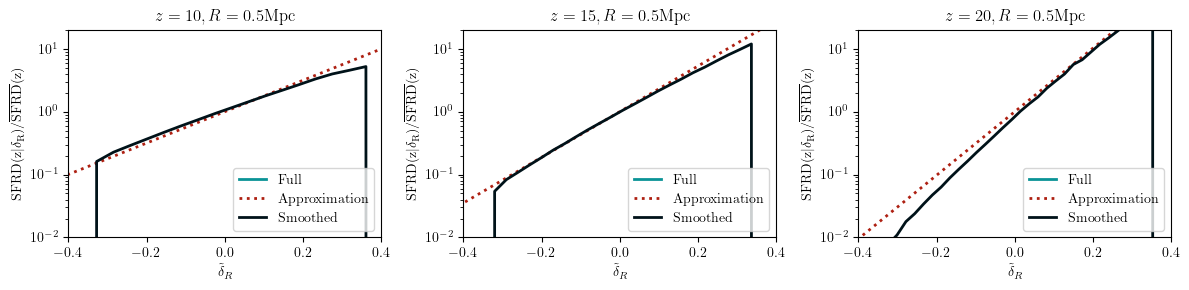

Doing R = 3 Mpc


KeyboardInterrupt: 

In [19]:
R_vals = [0.5,3,10]
for R in R_vals:
    print('Doing R = ' + str(R) + ' Mpc')
    compare_SFRD(R, [10,15,20], Lbox, Nbox, PS21_use, CoeffStructure_21_use,CosmoParams_use,HMFintclass_use,AstroParams_use,LineParams_use)